#DFKI Internship Task
Author: Saketh Bachu

Link to the models, resultant images: [DFKI_task](https://github.com/sakethbachu/DFKI_task)

## Downloading the dataset from a link
* The dataset is initially downloaded in the form of zip file and the contents are unzipped using the !unzip command into the colab local machine
* Dataset credit: [Udacity](https://www.udacity.com/)
* **Note**: Please check the hyperlinks, because some of the images are added as links. I have uploaded them to imgur and provided the link, to make the notebook load faster

In [1]:
import os
import urllib.request
urllib.request.urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip', 'dogImages.zip')

('dogImages.zip', <http.client.HTTPMessage at 0x7fcf81e0cb38>)

## Importing necessary packages
* The majority of this notebook uses [pytorch](https://pytorch.org/)
* Any graphs if present are produced using matlplotlib
* The main model that is of our interest is the [ResNet50](https://www.researchgate.net/publication/334767096/figure/fig1/AS:786356414455808@1564493387780/The-architecture-of-ResNet50-and-deep-learning-model-flowchart-a-b-Architecture-of.ppm)
* The images are visualized using Image grid
* We will be utilizing the GPU provided by Google Colab, thank you Google :)

In [21]:
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
#there was an error which was "unable to load truncated images"
#fixed it with the below lines 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from google.colab.patches import cv2_imshow

## Unzipping the dataset and inflate them into the local folder
* The zip folder is unzipped using the !unzip command
* Folder overview: 
  * The dataset contains images of dogs segregated into different folders,    whose titles are the breed names of the dogs.  
  * Number of classes i.e breeds are 133 
  * train: Used to train the model
  * test: The tests are based on this dataset
  * valid: The model is validated on this set of images


In [ ]:
!unzip '/content/dogImages.zip'

## Loading the names and just checking the length of the dataset
* This is done just to verify that the dataset has loaded properly and also to check the number of images.

In [38]:
# load filenames of dog images
dog_files = np.array(glob("/content/dogImages/*/*/*"))
# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


## Defining the dataloaders and their transforms
* **Reason to choose the cropsize and types of transforms** : 
* **Reason for centre crop** : I assumed that in majority of pictures, dog's face will be approximately in the centre area (face is considered becuase it is the most important part in decison making of the dog breed)
* **Reason for (224, 224, 3) size**: It is due to the prescribed input size for ResNet50

In [42]:
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
## Specify appropriate transforms, and batch_sizes
data_dir = '/content/dogImages'
data_dir1 = 'content'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
blur_dir = data_dir + '/blur'
hsv_dir = data_dir + '/hsv'

train_transforms = transforms.Compose([transforms.RandomRotation(30), #the rotations will be from -30degrees to 30degrees
                                       transforms.RandomResizedCrop(225), #the cropped size will be (225, 225)
                                       transforms.RandomHorizontalFlip(), #flip the images horizontally
                                       transforms.ToTensor(), #convert the numpy.nd.array to a torch tensor
                                       transforms.Normalize([0.485, 0.456, 0.406],   #this accounts to the normalisation in each channel
                                                            [0.229, 0.224, 0.225])]) #this is basically done in order to remove the hierarchy of pixel values


valid_transforms = transforms.Compose([transforms.Resize(256), #resized initially and then,
                                       transforms.CenterCrop(224),  #the cropped size will be (224, 224), note that it will be cropped at the centre
                                       transforms.ToTensor(),  #convert the numpy.nd.array to a torch tensor
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255), #resized initially and then,
                               transforms.CenterCrop(224), #the cropped size will be (224, 224), note that it will be cropped at the centre
                               transforms.ToTensor(), #convert the numpy.nd.array to a torch tensor
                                       transforms.Normalize([0.485, 0.456, 0.406], #this accounts to the normalisation in each channel
                                                            [0.229, 0.224, 0.225])])#this is basically done in order to remove the hierarchy of pixel values

test_transforms = transforms.Compose([transforms.Resize(255), #resized initially and then,
                               transforms.CenterCrop(224), #the cropped size will be (224, 224), note that it will be cropped at the centre
                               transforms.ToTensor(), #convert the numpy.nd.array to a torch tensor
                                       transforms.Normalize([0.485, 0.456, 0.406], #this accounts to the normalisation in each channel
                                                            [0.229, 0.224, 0.225])])#this is basically done in order to remove the hierarchy of pixel values
#Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
check_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
# blur_data = datasets.ImageFolder(blur_dir, transform=test_transforms)
hsv_data = datasets.ImageFolder(hsv_dir, transform=test_transforms)


#Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64,shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64,shuffle=False)
checkloader = torch.utils.data.DataLoader(train_data, batch_size=1,shuffle=False) #this dataloader will be used for testing where we require on one image in the form of a tensor
# blurloader = torch.utils.data.DataLoader(blur_data, batch_size=9,shuffle=False) #this dataloader will be used for testing where we require on one image in the form of a tensor(blur)
hsvloader = torch.utils.data.DataLoader(hsv_data, batch_size=9,shuffle=False) #this dataloader will be used for testing where we require on one image in the form of a tensor(hsv)

#This dataloader dictionary can be used wherever we want one of the 4 listed below are to be accessed
loaders_transfer = {'train':trainloader,
                  'valid':validloader,
                  'test':testloader,
                  'check':checkloader,
                  # 'blur':blurloader 
                  'hsv':hsvloader 

                  }
data_transfer = {
    'train':trainloader
}

In [6]:
#fetching the classnames for the images present in the the train loader
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

In [7]:
#fetching the classnames for the images present in the the check loader
class_names1 = [item[4:].replace("_", " ") for item in loaders_transfer['check'].dataset.classes]

In [51]:
# Denormalize and show
def imshow(axis, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #defining the values of mean and std to denormalise the normalised images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #the formula for denormalising the input images
    inp = std * inp + mean
    
    axis.imshow(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

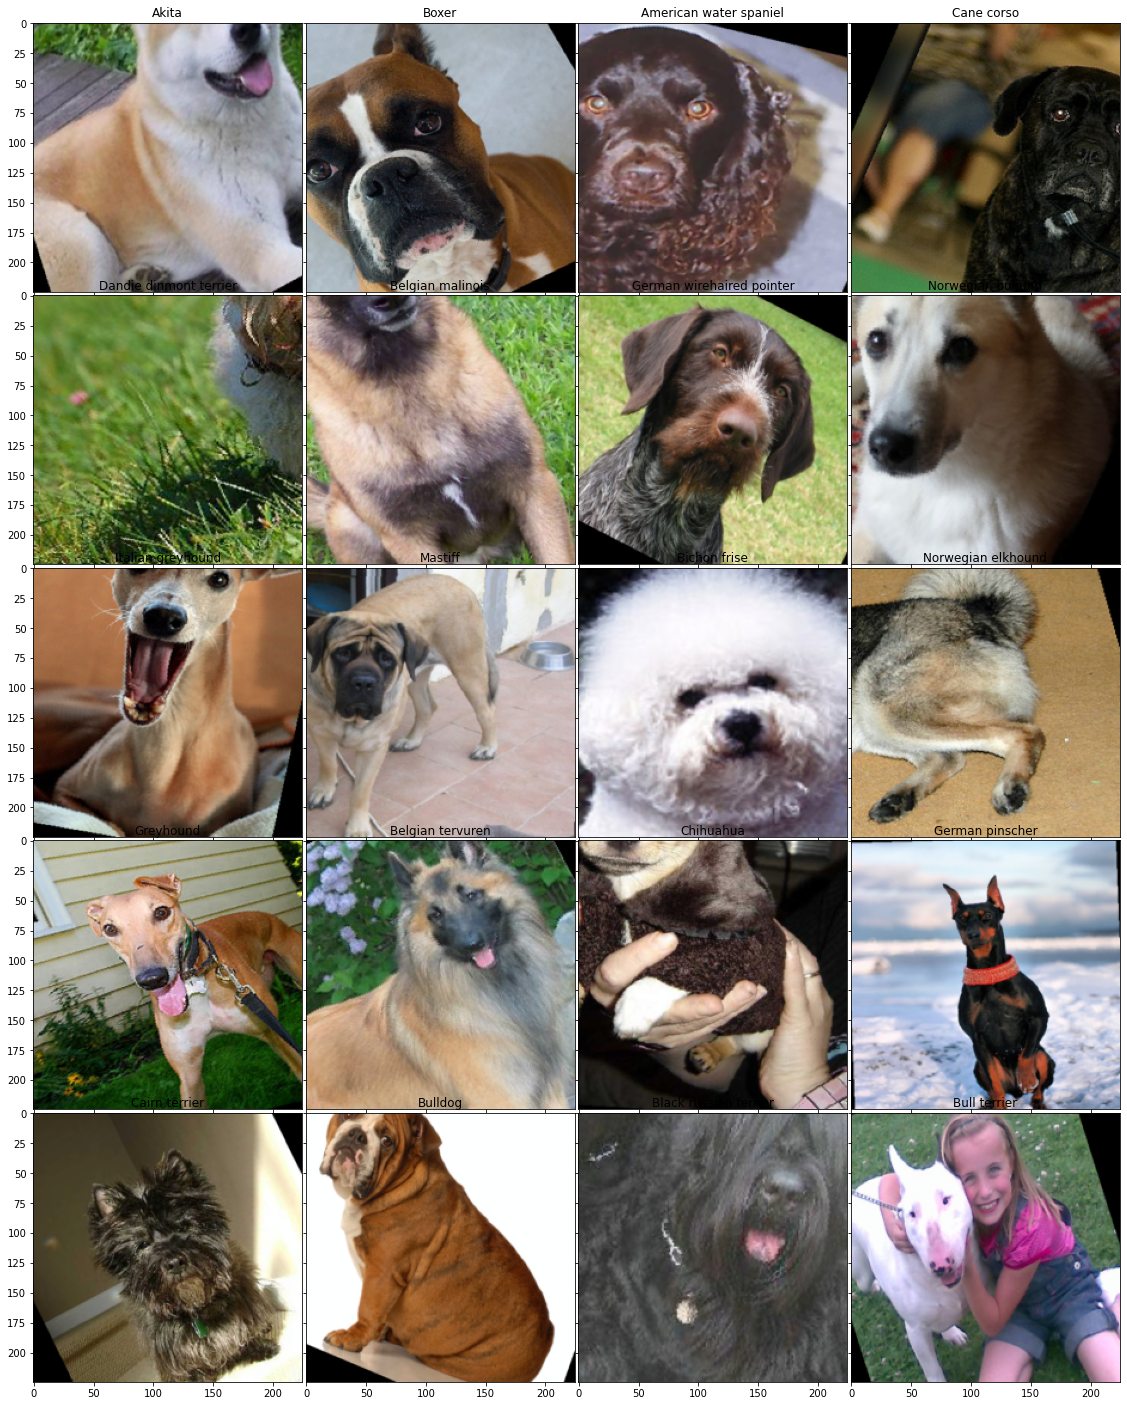

In [9]:
# defining the grid for displaying the images just to check and visualize them
import matplotlib.pyplot as plt
img, label = next(iter(trainloader))
fig = plt.figure(1, figsize=(25, 25))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.05)    
for i in (range(img.size()[0])):
    ax = grid[i]
    res_list = [class_names[i] for i in label] #as we want to visualize images from trainloader
    label_dog = res_list[i]
    ax.set_title(label_dog, fontdict=None, loc='center', color = "k")
    imshow(ax, img[i])


In [46]:
import torchvision.models as models
import torch.nn as nn

##Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for name, param in model_transfer.named_parameters(): #freezing all the parameters (grad) initially as we dont want to train the entire pretrained Network
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133, bias=True)    #replacing last fc with custom fully-connected layer which should output 133 sized vector

fc_parameters = model_transfer.fc.parameters()         #extracting fc parameters
for param in fc_parameters:
    param.requires_grad = True                         #allowing only the fc layers to unfreeze and those will be trained with the dogbreed dataset

use_cuda = torch.cuda.is_available()                   #checking for cuda 

if use_cuda:
    model_transfer = model_transfer.cuda()             #if available we transfer the model to the gpu


In [11]:
#sanity check for the grads, only the fc layer is unfreezed as we are going to update the weights only of the fc layers
for name, param in model_transfer.named_parameters():
    print(name, ':', param.requires_grad)

conv1.weight : False
bn1.weight : False
bn1.bias : False
layer1.0.conv1.weight : False
layer1.0.bn1.weight : False
layer1.0.bn1.bias : False
layer1.0.conv2.weight : False
layer1.0.bn2.weight : False
layer1.0.bn2.bias : False
layer1.0.conv3.weight : False
layer1.0.bn3.weight : False
layer1.0.bn3.bias : False
layer1.0.downsample.0.weight : False
layer1.0.downsample.1.weight : False
layer1.0.downsample.1.bias : False
layer1.1.conv1.weight : False
layer1.1.bn1.weight : False
layer1.1.bn1.bias : False
layer1.1.conv2.weight : False
layer1.1.bn2.weight : False
layer1.1.bn2.bias : False
layer1.1.conv3.weight : False
layer1.1.bn3.weight : False
layer1.1.bn3.bias : False
layer1.2.conv1.weight : False
layer1.2.bn1.weight : False
layer1.2.bn1.bias : False
layer1.2.conv2.weight : False
layer1.2.bn2.weight : False
layer1.2.bn2.bias : False
layer1.2.conv3.weight : False
layer1.2.bn3.weight : False
layer1.2.bn3.bias : False
layer2.0.conv1.weight : False
layer2.0.bn1.weight : False
layer2.0.bn1.bias : 

In [12]:
import torch.optim as optim
#using the crossEntropy loss
criterion_transfer = nn.CrossEntropyLoss()
#optimizing(using Stochastic gradient descent) only the fc layers
#setting the lr to 0.001
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # watch training
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

## Task 1: Train the ResNet50 model with the dog breed dataset

In [ ]:
# train the model
#num of epochs = 40
model_transfer =  train(40, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch 1, Batch 1 loss: 4.919814
Epoch 1, Batch 101 loss: 4.911186
Epoch 1, Batch 201 loss: 4.880711
Epoch 1, Batch 301 loss: 4.853698
Epoch: 1 	Training Loss: 4.845577 	Validation Loss: 4.673418
Validation loss decreased (inf --> 4.673418).  Saving model ...
Epoch 2, Batch 1 loss: 4.707755
Epoch 2, Batch 101 loss: 4.724941
Epoch 2, Batch 201 loss: 4.705962
Epoch 2, Batch 301 loss: 4.687529
Epoch: 2 	Training Loss: 4.681222 	Validation Loss: 4.461798
Validation loss decreased (4.673418 --> 4.461798).  Saving model ...
Epoch 3, Batch 1 loss: 4.565692
Epoch 3, Batch 101 loss: 4.578700
Epoch 3, Batch 201 loss: 4.563290
Epoch 3, Batch 301 loss: 4.546200
Epoch: 3 	Training Loss: 4.536931 	Validation Loss: 4.255750
Validation loss decreased (4.461798 --> 4.255750).  Saving model ...
Epoch 4, Batch 1 loss: 4.466950
Epoch 4, Batch 101 loss: 4.454075
Epoch 4, Batch 201 loss: 4.426988
Epoch 4, Batch 301 loss: 4.407854
Epoch: 4 	Training Loss: 4.402619 	Validation Loss: 4.063159
Validation loss de

In [33]:
# load the model that got the best validation accuracy 
model_transfer.load_state_dict(torch.load('model_transfer_main.pt'))

<All keys matched successfully>

In [34]:
#defining a function to calculate accuracies
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    preds = []
    targets = []
        
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return preds,targets

## Checking with the test set
* We load our retrained model and check for the accuracy on test set
* This involves the concept of [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)


In [35]:
# we are calculating accuracy of our trained model or the subsequent randomized model 
preds, gts = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.007440


Test Accuracy: 79% (665/836)


## Task-2  Visualizing occlusion sensitivity

**Referred paper**: https://arxiv.org/pdf/1311.2901.pdf

**My views on occlusion sensitivity:**

* **The main aim** is to open up the CNN-black box and ensure that a CNN is learning meaningful features through numerous experiments, for example in this case the meaningful feature for dog breed classification would be to extract, learn, and detect features of a dog’s face but not the features of its body.

* **My Task**: To implement the occlusion sensitivity technique on the dog-breed dataset.
Types of occlusions applied: Black color mask, blur mask, and color change mask, all of them in a sliding window fashion to test out with multiple location placement of the masks.

* **Conclusions**: 1) The work published in the paper is very useful to check the visualizations of the model and diagnose it.
2) From the basics of the deep neural network, I was able to appreciate the fact that convolutional neural networks visualize the features in a constructive manner, which means the initial layers visualize simple features such as edges and corners but the consequent layers detect intricate and [complex shapes](https://imgur.com/a/m65nhJb). This was well displayed in the de-convnet visualization( unpooling -> Relu -> Conv Filter (with the transpose of previous convolutional layer’s weights ) whose results were shown in figure 2 of the paper.
3) Another noteworthy point is that the convolutional layers extract many features but the ultimate decision to pick up the meaningful and relevant features from these lies with the classification layer. This again is dependent on what we are optimizing on.


In [ ]:
"""

code credits: https://github.com/hans66hsu/nn_interpretability

"""

import torch
from torch.nn import Module
from torchvision import transforms

#defining couple of helper functions to interpret a tensor after applying various occlusions
class Interpreter:
    """
    Implements an abstract Interpreter which serves as a base
    for any interpretation method.
    """

    def __init__(self, model: Module, classes: [str], preprocess: transforms.Compose):
        """
        :param model: The model the decisions of which needs to be interpreted.
        :param classes: A collection of all classes that the given model can classify
        :param preprocess: The preprocessing functions that need to be invoked for the model input.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model: Module = model
        self.model.train()
        self.model = self.model.to(self.device)

        self.classes = classes
        self.preprocess = preprocess

        self._last_prediction = -1

    def _execute_preprocess(self, x):
        if self.preprocess:
            x = self.preprocess(x)

        return x.to(self.device)

    def _one_hot(self, output, class_idx):
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1.0
        return one_hot.to(self.device)

    def normalize(self, x):
        return ((x - x.min()) / (x.max() - x.min())).to(self.device)

    def last_prediction(self):
        return self._last_prediction


class ModelInterpreter(Interpreter):
    """
    Implements an abstract ModelInterpreter which serves as a base
    for any model-based interpretation method.
    """
    def __init__(self, model: Module, classes: [str], preprocess: transforms.Compose):
        """
        :param model: The model the decisions of which needs to be interpreted.
        :param classes: A collection of all classes that the given model can classify
        :param preprocess: The preprocessing functions that need to be invoked for the model input.
        """
        Interpreter.__init__(self, model, classes, preprocess)

    def interpret(self):
        """
        Provides an interpretation for the specified model.
        """
        pass


class DecisionInterpreter(Interpreter):
    """
    Implements an abstract DecisionInterpreter which serves as a base
    for any decision-based interpretation method.
    """
    def __init__(self, model: Module, classes: [str], preprocess: transforms.Compose):
        """
        :param model: The model the decisions of which needs to be interpreted.
        :param classes: A collection of all classes that the given model can classify
        :param preprocess: The preprocessing functions that need to be invoked for the model input.
        """
        Interpreter.__init__(self, model, classes, preprocess)

    def interpret(self, x):
        """
        Provides an interpretation for the decision of the specified model for the defined input.
        :param x: The input which will be fed into the specified model.
        :return:
        """
        pass

In [ ]:
from torch.nn import Module
import torch.nn.functional as F
from torchvision.transforms import transforms

#defining a set of functions to apply occlusions to images and then test their effect on the accuracy 
class OcclusionSensitivity(DecisionInterpreter):
    """
    OcclusionSensitivity is a decision-based intepretability method which obstructs
    parts of the input in order to see what influence these regions have to the
    output of the model under test.
    """
    def __init__(self, model: Module, classes: [str], preprocess: transforms.Compose, input_size, block_size, fill_value, target):
        """
        :param model: The model the decisions of which needs to be interpreted.
        :param classes: A collection of all classes that the given model can classify
        :param preprocess: The preprocessing functions that need to be invoked for the model input.
        :param input_size: The expected 2D input size by the given model (e.g. (28, 28))
        :param block_size: The size of the 2D block which acts as occlusion.
                            This should be a divisor of each dimension of the input size! (e.g. (7, 7))
        :param fill_value: The value for the occlusion block
        :param target: The target class of the expected input
        """
        DecisionInterpreter.__init__(self, model, classes, preprocess)
        self.input_size = input_size
        self.block_size = block_size
        self.fill_value = fill_value
        self.target = target

        if self.input_size[0] % self.block_size[0] != 0 or self.input_size[1] % self.block_size[1] != 0:
            raise ValueError("The block size should be a divisor of the input size.")
     
    # a function to apply black mask occlusion to images in a sliding window fashion
    def _generate_occlused_input(self, x):
        out = []

        rows = int(self.input_size[0] / self.block_size[0])
        columns = int(self.input_size[1] / self.block_size[1])

        for row in range(rows):
            for column in range(columns):
                # print(type(x))
                #initially detaching the tensor and then transferring to the device
                new_x = x.clone().detach().to(self.device)
                #applying the mask of black pixels in all the 3 channels as its an rgb image
                new_x[0][0][row * self.block_size[0]: (row + 1) * self.block_size[0], column * self.block_size[1]: (column + 1) * self.block_size[1]] = self.fill_value[0]
                new_x[0][1][row * self.block_size[0]: (row + 1) * self.block_size[0], column * self.block_size[1]: (column + 1) * self.block_size[1]] = self.fill_value[1]
                new_x[0][2][row * self.block_size[0]: (row + 1) * self.block_size[0], column * self.block_size[1]: (column + 1) * self.block_size[1]] = self.fill_value[2]                
                out.append(new_x)

        return out
    
    #computing probabilities of the occluded samples of them belonging to the actual class
    def _compute_probabilities(self, x):
        probabilities = []

        for i in range(len(x)):
            logits = self.model(x[i]).to(self.device)
            probs = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
            prob = np.round(probs[self.target], 2)
            probabilities.append(prob)

        return probabilities

    #the function which calls the above to functions in addition to preprocessing
    def interpret(self, x):
        x = self._execute_preprocess(x)
        
        # print(x.shape)
        #x should be a single image-tensor(ie batch size 1)
        occluded_input = self._generate_occlused_input(x)
        probabilities = self._compute_probabilities(occluded_input)
        # print(occluded_input[0].shape)
        occluded_input = [img.cpu() for img in occluded_input]

        #returing the array of occluded images and their probabilities of belonging to the actual class
        return occluded_input, probabilities


## Occlusion sensitivity with blur mask
* Introducing blur mask at multiple locations of the image to cover different parts in an image
* This is done using the sliding window approach

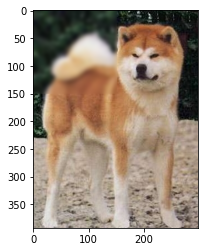

In [ ]:
#just a test function to implement the idea of part wise blur
img1 = cv2.imread("/content/dogImages/train/004.Akita/Akita_00220.jpg")
blurred_img = cv2.GaussianBlur(img1, (21, 21), 0)

mask = np.zeros((393, 297, 3), dtype=np.uint8)

mask = cv2.rectangle(mask, (0, 0), (150, 150), (255, 255, 255), -1) 

#appling the blur pixels where ever there is a white mask
out = np.where(mask!=np.array([255, 255, 255]), img1, blurred_img)

#changing the colour code to visualise in imshow
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

#checking whether my approach worked or not
plt.imshow(out)

In [ ]:
# now as the previous unit test worked, defining a function to create blur mask on multiple locations using a sliding window approach
#stating the size of the image
input_size = (225, 225)
#stating the size of the mask that has to be applied at each instance
block_size = (75, 75)
def _generate_occlused_input_with_blur(x):
    out1 = []
    gen = []
    rows = int(input_size[0] / block_size[0])
    columns = int(input_size[1] / block_size[1])

    for row in range(rows):
        for column in range(columns):

            test = x
            
            #converting the tensor to a numpy array, changing the dimensions and denormalising to apply opencv related functions
            test = test.reshape(3, 225, 225)
            # test = test.cpu().detach().numpy()
            # new_x = x.clone().detach().to(self.device)
            test = test.numpy().transpose((1, 2, 0))
            # mean = np.array([0.485, 0.456, 0.406])
            # std = np.array([0.229, 0.224, 0.225])
            mean = np.array([116.79, 116.28, 103.53])
            std = np.array([58.395, 57.12, 57.375])
            test = std * test + mean #denormalising
            
            
             
            test = np.array(test, dtype=np.uint8)

            # test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)


            blurred_img = cv2.GaussianBlur(test, (21, 21), 0)

            start_point = ((row * block_size[0]), (column * block_size[1]))

            end_point = (((row + 1) * block_size[0]), ((column + 1) * block_size[1]))
            # print(start_point)
            # print(end_point)


            mask = np.zeros((225, 225, 3), dtype=np.uint8)
            
            mask = cv2.rectangle(mask, start_point, end_point, (255, 255, 255), -1) 

            outer = np.where(mask!=np.array([255, 255, 255]), test, blurred_img)
            
            outer = np.array(outer, dtype=np.uint8)
 

            outer = cv2.cvtColor(outer, cv2.COLOR_BGR2RGB)

            a = outer

            gen.append(a)

            # outer = np.array(outer, dtype=np.float64)

            outer = (outer - mean)/std

            
            outer = torch.from_numpy(outer)

            outer = outer.reshape(1, 3, 225, 225)
            
            # print(test.shape)
            out1.append(outer)

    return out1, gen

In [48]:
#defining a function to calculate the probabilities of the blurred images as a part of occlusion sensitivity
import torch.nn.functional as F
def _compute_probabilities1(x):
    probabilities = []
    target = 0
    for i in range(len(x)):
        f = x[i]
        f = f.reshape(1, 3, 224, 224)
        logits = model_transfer(f)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
        prob = np.round(probs[target], 2)
        probabilities.append(prob)

    return probabilities

**Note**: There was some problem with normalising the images again because, as soon as the array was normalised and converted to tensor, something strange would happen and the actual image used to turn into a meaningless pixel matrix. Hence applied the blur mask manually and saved them to a folder and then loaded them using the dataloader and then passed to the model and calculated the probabilities of them belonging to the actual class.

In [ ]:
#loading the blur images and 
img1, l1  = next(iter(blurloader))

#computed probabilities
probabilities = _compute_probabilities1(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


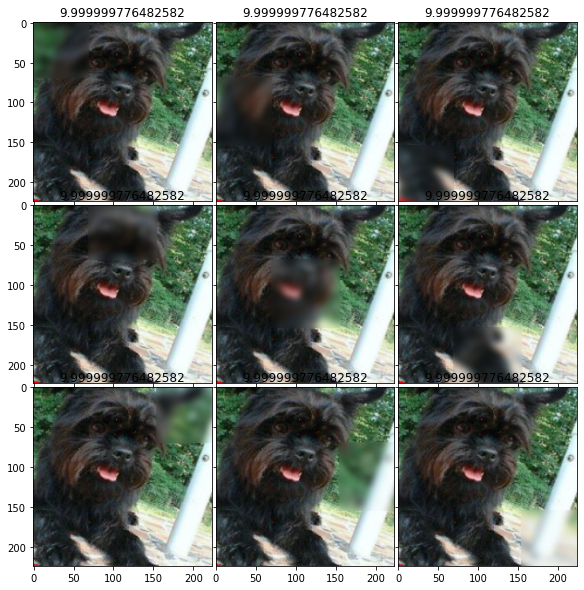

In [ ]:
# displaying the blurred images with their probabilities in a grid fashion
fig = plt.figure(1, figsize=(20, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)    
for i in (range(0,9)):
    ax = grid[i]    
    label_dog = probabilities[i] * 1000
    ax.set_title(label_dog, fontdict=None, loc='center', color = "k")
    imshow(ax, img1[i])

## Reason for low probabilities
Accoding to me there might be two reasons for this:
* There is some problem in my _compute_probabilities1 function
* The probabilities are low due to the application of softmax across 133 classes, while calculating accuracy we consider the max of the logits vector and consider it as the prediction

## Occlusion sensitivity with hsv mask
* Introducing hsv mask at multiple locations of the image to cover different parts in an image
* This is done using the sliding window approach

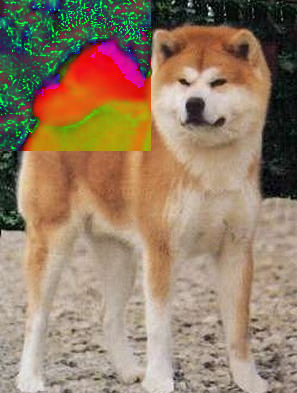

True

In [23]:
#just a test function to implement the idea of part wise hsv scale conversion
img1 = cv2.imread("/content/dogImages/train/004.Akita/Akita_00220.jpg")
blurred_img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

mask = np.zeros((393, 297, 3), dtype=np.uint8)

mask = cv2.rectangle(mask, (0, 0), (150, 150), (255, 255, 255), -1) 

# #appling the blur pixels where ever there is a white mask
out = np.where(mask!=np.array([255, 255, 255]), img1, blurred_img)

#checking whether my approach worked or not
cv2_imshow(out)  
cv2.imwrite("cam.jpg", out)

In [26]:
# now as the previous unit test worked, defining a function to create hsv mask on multiple locations using a sliding window approach
#stating the size of the image
input_size = (225, 225)
#stating the size of the mask that has to be applied at each instance
block_size = (75, 75)
def _generate_occlused_input_with_blur(x):
    out1 = []
    gen = []
    rows = int(input_size[0] / block_size[0])
    columns = int(input_size[1] / block_size[1])

    for row in range(rows):
        for column in range(columns):

            test = x
            
            #converting the tensor to a numpy array, changing the dimensions and denormalising to apply opencv related functions
            test = test.reshape(3, 225, 225)
            # test = test.cpu().detach().numpy()
            # new_x = x.clone().detach().to(self.device)
            test = test.numpy().transpose((1, 2, 0))
            # mean = np.array([0.485, 0.456, 0.406])
            # std = np.array([0.229, 0.224, 0.225])
            mean = np.array([116.79, 116.28, 103.53])
            std = np.array([58.395, 57.12, 57.375])
            test = std * test + mean #denormalising
            
            
             
            test = np.array(test, dtype=np.uint8)

            # test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)


            blurred_img = cv2.cvtColor(test, cv2.COLOR_BGR2HSV)

            start_point = ((row * block_size[0]), (column * block_size[1]))

            end_point = (((row + 1) * block_size[0]), ((column + 1) * block_size[1]))
            # print(start_point)
            # print(end_point)


            mask = np.zeros((225, 225, 3), dtype=np.uint8)
            
            mask = cv2.rectangle(mask, start_point, end_point, (255, 255, 255), -1) 

            outer = np.where(mask!=np.array([255, 255, 255]), test, blurred_img)
            
            outer = np.array(outer, dtype=np.uint8)
 

            outer = cv2.cvtColor(outer, cv2.COLOR_BGR2RGB)

            a = outer

            gen.append(a)

            # outer = np.array(outer, dtype=np.float64)

            outer = (outer - mean)/std

            
            outer = torch.from_numpy(outer)

            outer = outer.reshape(1, 3, 225, 225)
            
            # print(test.shape)
            out1.append(outer)

    return out1, gen

In [27]:
img1, l = next(iter(checkloader))
a, b = _generate_occlused_input_with_blur(img1)

**Note**: There was some problem with normalising the images again because, as soon as the array was normalised and converted to tensor, something strange would happen and the actual image used to turn into a meaningless pixel matrix. Hence applied the hsv mask manually and saved them to a folder and then loaded them using the dataloader and then passed to the model and calculated the probabilities of them belonging to the actual class.

In [49]:
#loading the hsv images and 
img1, l1  = next(iter(hsvloader))

#computed probabilities
probabilities = _compute_probabilities1(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


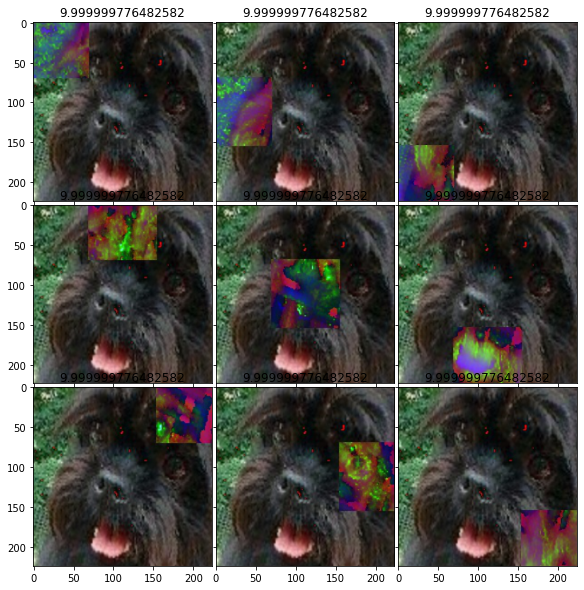

In [52]:
# displaying the hsv images with their probabilities in a grid fashion
fig = plt.figure(1, figsize=(20, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)    
for i in (range(0,9)):
    ax = grid[i]    
    label_dog = probabilities[i] * 1000
    ax.set_title(label_dog, fontdict=None, loc='center', color = "k")
    imshow(ax, img1[i])

## Reason for low probabilities
Accoding to me there might be two reasons for this:
* There is some in my _compute_probabilities1 function
* The probabilities are low due to the application of softmax across 133 classes, while calculating accuracy we consider the max of the logits vector and consider it as the prediction

## Occlusion with black mask
* Introducing black pixel mask at multiple locations of the image to cover different parts in an image
* This is done using the sliding window approach

In [ ]:
#stating the size of the image
input_size = (225, 225)
#stating the size of the mask that has to be applied at each instance
block_size = (75, 75)
# we want a black mask so we will replace the pixels with the following values
#note that these are channel wise normalised pixel values of the black color
fill_value = [-2.1179, -2.0357, -1.8044]
#calling the check loader to load the image that needs to be occluded
img, l = next(iter(checkloader))
#making an instance of the OcclusionSensitivity class and then calling the function that applies black mask
interpretor = OcclusionSensitivity(model_transfer, None, None, input_size, block_size, fill_value, 0) #0 is the label class of the image loaded using the check loader

images, probabilities = interpretor.interpret(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


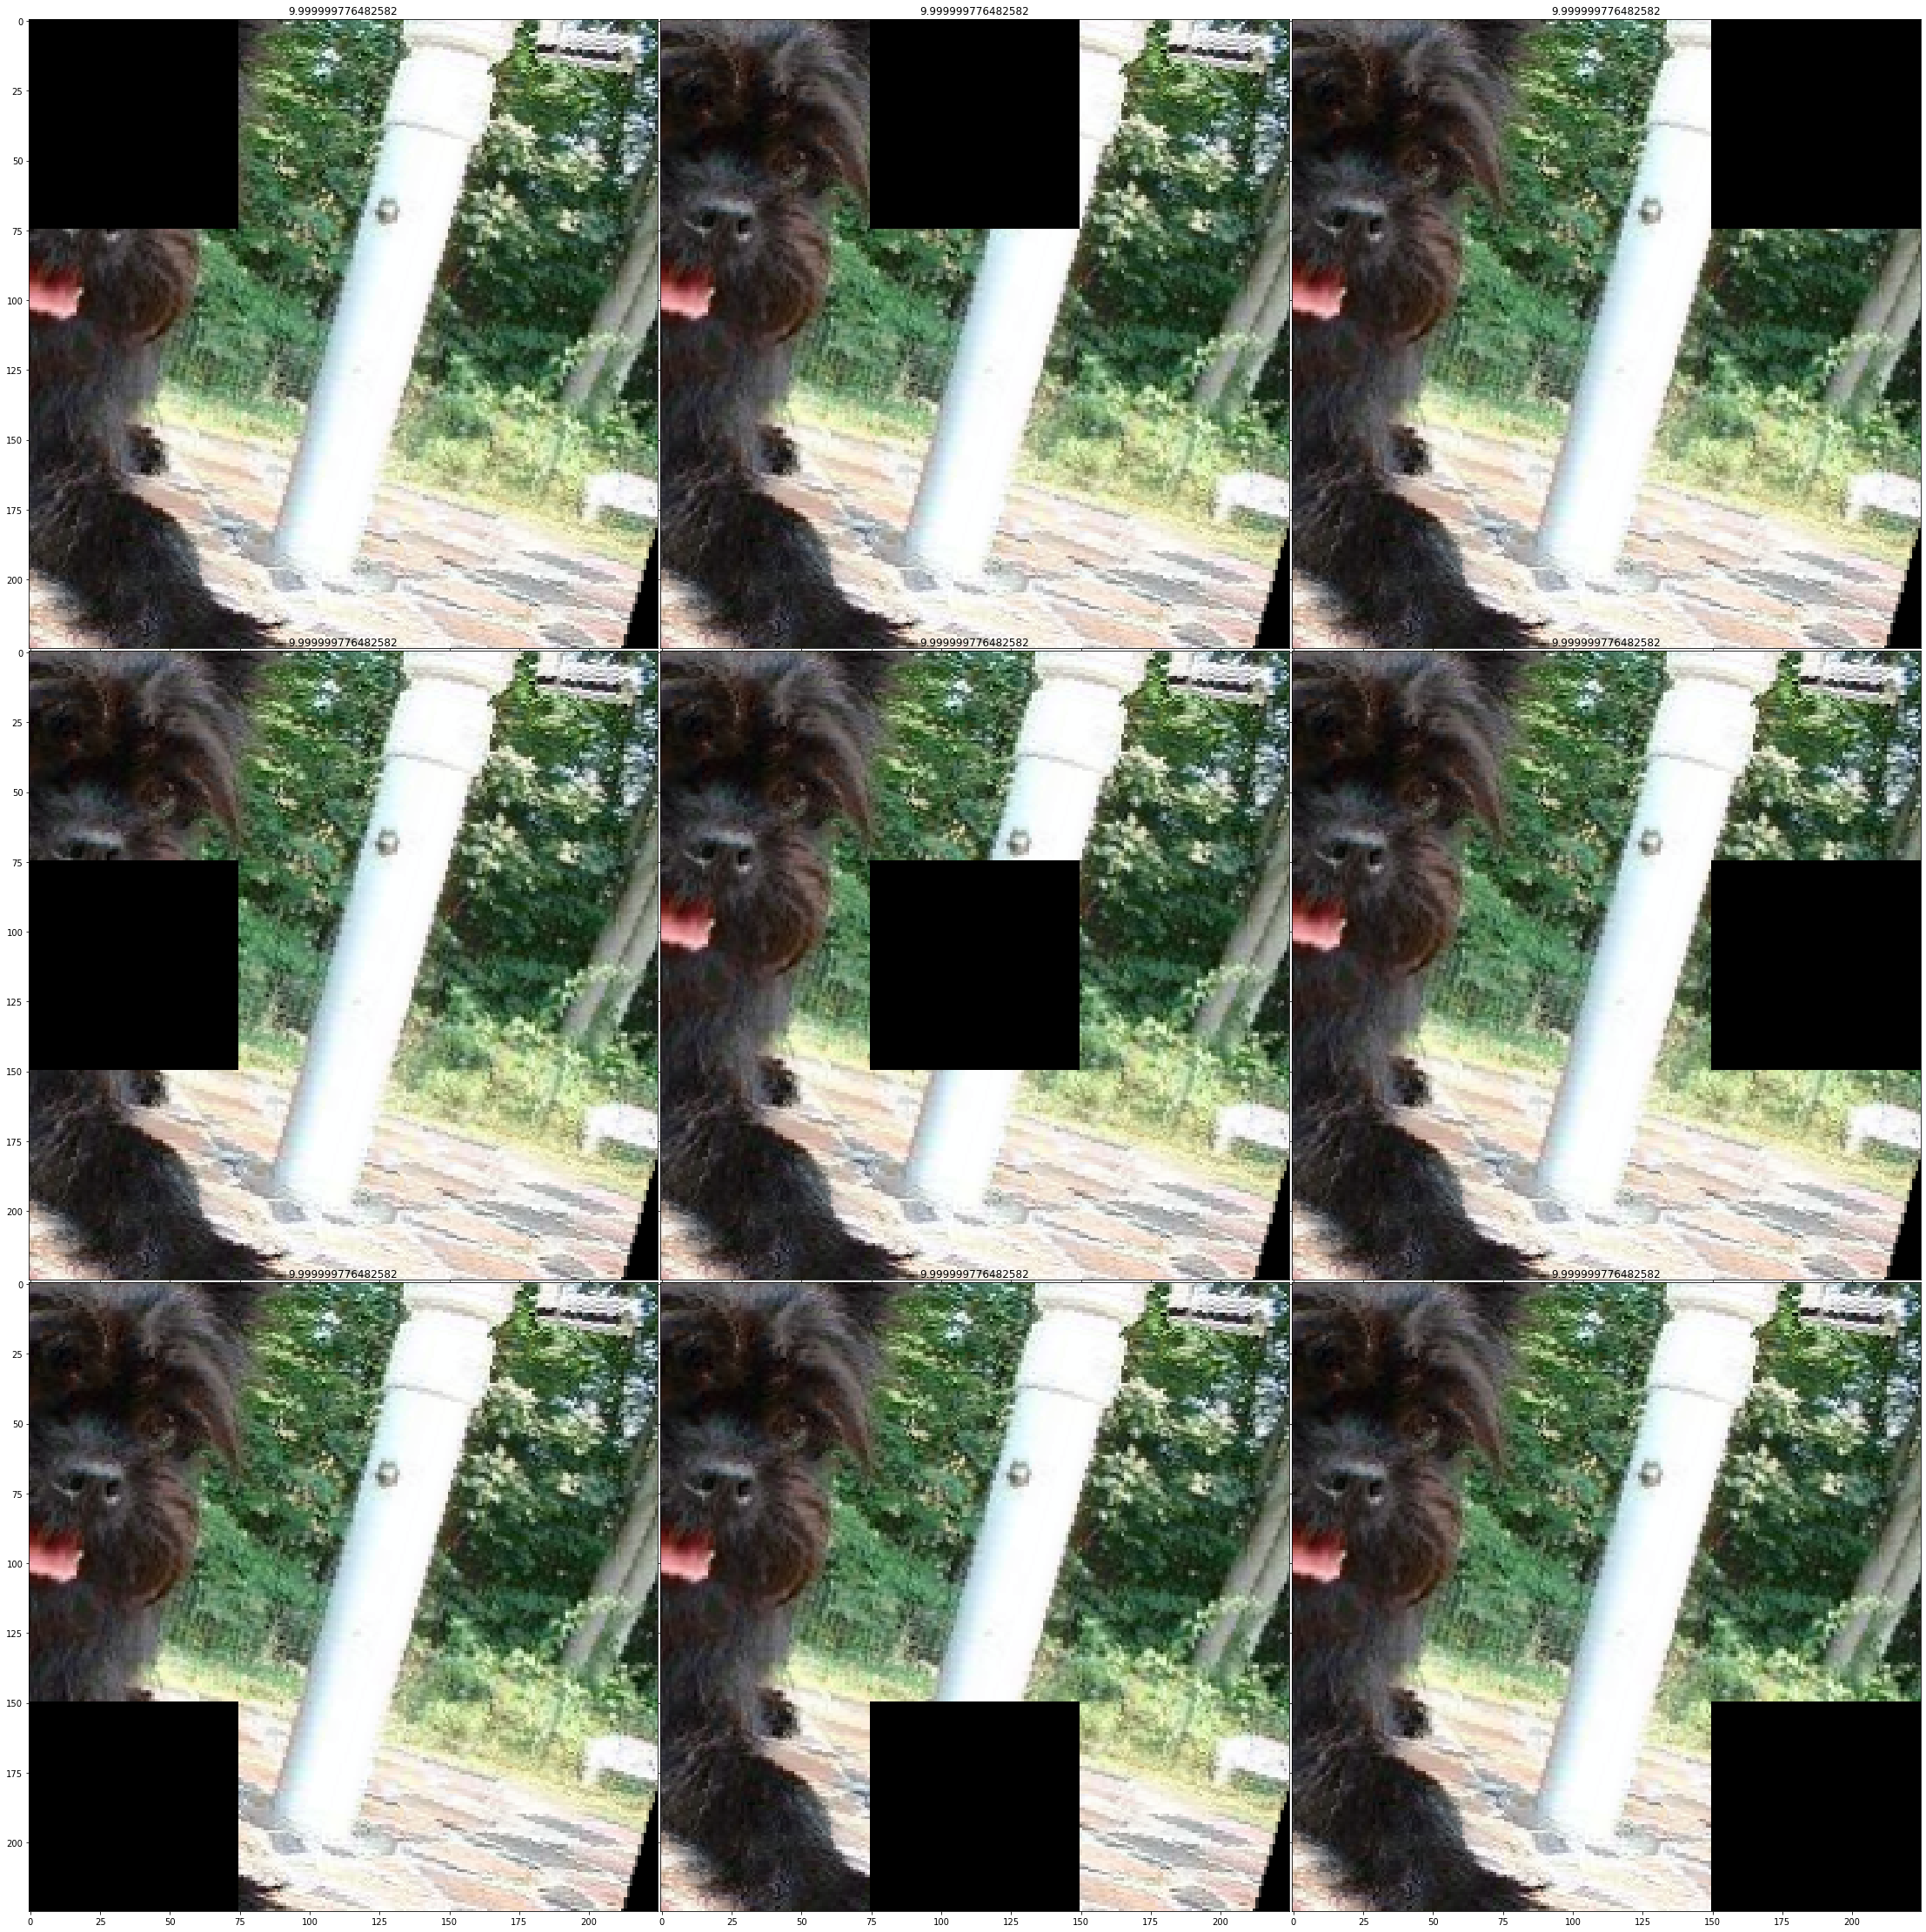

In [ ]:
#visualising the occluded images along with their probabilities of belonging to the actual class at every instance
fig = plt.figure(1, figsize=(80, 40))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)    
for i in (range(0,9)):
    ax = grid[i]    
    label_dog = probabilities[i] * 1000
    ax.set_title(label_dog, fontdict=None, loc='center', color = "k")
    imshow(ax, images[i].reshape(3, 225, 225))


# Task-3 Grad CAM

**Referred paper**: https://arxiv.org/pdf/1610.02391.pdf

**My views on Grad CAM and G-Grad CAM**:
* **The main proposal** of the paper is a  technique for producing ‘visual explanations’ for decisions from a large class of Convolutional Neural Network (CNN) - based models, making them more transparent and explainable.

* The Grad CAM is built on the drawbacks of the CAM.

* **Drawbacks of the CAM stated according to the Grad CAM paper** are: 1) it requires feature maps to directly precede the softmax layers, so it is applicable to a particular kind of CNN architectures that perform global average pooling over convolutional maps immediately before prediction. (i.e conv feature maps → global average pooling →softmax layer). Such architectures may achieve in inferior accuracies compared to general networks on some tasks or simply be inapplicable to new tasks.

* Source: https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48

* **Difference between average pooling and max pooling** are: 
* **Average Pooling**: Calculate the average value for each patch on the feature map. 
* **Maximum Pooling**: Calculate the maximum value for each patch of the feature map.

* **Working of the Grad CAM**: [Grad-Cam](https://imgur.com/a/cC4pW31), unlike CAM, uses the gradient information flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest.  It calculates the CAM mask based on the gradients of the correct class.

* The summary of the Grad CAM approach can be found in the paper.

* **Guided-Grad CAM**: According to the paper, while Grad-CAM is class-discriminative and localizes relevant image regions, it lacks the ability to highlight fine-grained details like pixel-space gradient visualization methods( intuition is that it doesn’t address intricacies in features like stripes on the face of a dog, its nose structure, etc)

* **Conclusion**: As mentioned above, Grad CAM localizes the maps very well. And also this method provides a better understanding compared to the previous method of the working and decision-making ideologies of CNN.

In [29]:
"""
code credits: https://github.com/jacobgil/pytorch-grad-cam

"""

import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):

        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermediate targetted layers. """

    def __init__(self, model, feature_module, target_layers):

        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))


class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):

        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):

        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output


# def get_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--use-cuda', action='store_true', default=False,
#                         help='Use NVIDIA GPU acceleration')
#     parser.add_argument('--image-path', type=str, default='./examples/both.png',
#                         help='Input image path')
#     args = parser.parse_args()
#     args.use_cuda = args.use_cuda and torch.cuda.is_available()
#     if args.use_cuda:
#         print("Using GPU for acceleration")
#     else:
#         print("Using CPU for computation")

#     return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)


In [30]:
# 1. Loads an image with opencv.
# 2. Preprocesses it for ResNet with fc layers and converts to a pytorch variable.
# 3. Makes a forward pass to find the category index with the highest score,
# and computes intermediate activations.
# Makes the visualization. """


# Can work with any model, but it assumes that the model has a
# feature method, and a classifier method,
# as in the VGG models in torchvision.
model = model_transfer
grad_cam = GradCam(model=model, feature_module=model.layer4, \
                  target_layer_names=["2"], use_cuda=use_cuda)

img = cv2.imread("/content/dogImages/train/004.Akita/Akita_00225.jpg", 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

show_cam_on_image(img, mask)

gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda)
print(model._modules.items())
gb = gb_model(input, index=target_index)
gb = gb.transpose((1, 2, 0))
cam_mask = cv2.merge([mask, mask, mask])
cam_gb = deprocess_image(cam_mask*gb)
gb = deprocess_image(gb)

cv2.imwrite('gb.jpg', gb)
cv2.imwrite('cam_gb.jpg', cam_gb)

odict_items([('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), ('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('relu', <built-in method apply of FunctionMeta object at 0xa47f0d8>), ('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)), ('layer1', Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): <built-in method apply of FunctionMeta object at 0xa47f0d8>
    (downsample): 

True

# Task-4 Randomizing weights and visualizing through Grad CAM

In [ ]:
#checking the names of the parameters
for name, param in model1.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

In [ ]:
"""
code ccredits: https://gist.github.com/jkleint/eb6dc49c861a1c21b612b568dd188668

"""
#defining a base function for permuting(randomizes) weights
#the idea of permuting our ResNet weights is taken from this function
def shuffle_weights(weights):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """

    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    return weights

In [ ]:
#based on the above function we declare our modified function which can shuffle weights in an iterative manner
#this function is used for full model weights randomization
def shuffle_weights_m(weights):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    updated = [] #list for updated weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #declaring the device

    for i in range(0, len(weights)):
      s = weights[i].shape
      test = weights[i]
      #for all weights except biases, ignored because they are generally small values
      if len(s) >=  2:
        #for a 4d tensor ex(64, 1, 1, 1) or a 2d tensor (fc weight) ex(132,2048)
        if s[1] == 1 and s[2] == 1:
          a = s[0]/2
          test = test.reshape(int(a), int(a))
          test = test.cpu().detach().numpy()
          test = np.random.permutation(test.flat).reshape(test.shape)
          test = torch.from_numpy(test).to(device)
          updated.append(test)

        else:
          test = test.cpu().detach().numpy()
          test = np.random.permutation(test.flat).reshape(test.shape)
          test = torch.from_numpy(test).to(device)
          updated.append(test)
      
      else:
        updated.append(test)


    return updated #returning the randomized weights

In [37]:
#this function is used for half model weights randomization
def shuffle_weights_m2(weights):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    updated = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for i in range(0, int(len(weights)/2)):
      s = weights[i].shape
      test = weights[i]
      #for all weights except biases, ignored because they are generally small values
      if len(s) >=  2:
        #for a 4d tensor ex(64, 1, 1, 1) or a 2d tensor (fc weight) ex(132,2048)
        if s[1] == 1 and s[2] == 1:
          a = s[0]/2
          test = test.reshape(int(a), int(a))
          test = test.cpu().detach().numpy()
          test = np.random.permutation(test.flat).reshape(test.shape)
          test = torch.from_numpy(test).to(device)
          updated.append(test)

        else:
          test = test.cpu().detach().numpy()
          test = np.random.permutation(test.flat).reshape(test.shape)
          test = torch.from_numpy(test).to(device)
          updated.append(test)
      
      else:
        updated.append(test)

    # weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    return updated

In [ ]:
names = [] #capturing the names of the parameters to access the values of the ordered dict
n1 = [] #capturing the weights of the trained model
for name, param in model_transfer.named_parameters():
    n1.append(param)
    names.append(name)

In [ ]:
n3 = shuffle_weights_m(n1) #shuffling the weights of all the layers

In [ ]:
n2 = shuffle_weights_m2(n1) #shuffling the weights of half of the layers

In [ ]:
# for i in range(len(n2)):
#updating the weights using a similar function(not this in all the three case)
model_transfer.state_dict()['fc.weight'].copy_(n2)

In [ ]:
torch.save(model_transfer.state_dict(), 'weights_random_logit.pt')#as the code is reused, this is for the last part of logit weight randomization

In [24]:
model_transfer.load_state_dict(torch.load('weights_random_logit.pt'))#saving the randomized model

<All keys matched successfully>

## Conclusions made after randomizing the weights at three levels
* **Levels of randomization**: 1) Full model 2) Half, from the top 3) Logit layer
* **Trained Model**: The Grad-CAM gives good visualization by activating pixels on the face of a dog
* **Full model random**: The Grad CAM activates the pixels randomly all over the image, nothing meaningful
* **Half model random**: Meaningful insights can be taken, the back prop and guided Grad CAM slightly highlight the dog body. This due to the other half and fc layer weights(which are not shuffled) which capture high level features(intricate and complex)
* **Logit layer random**: This becomes equivalent to a pretrained ResNet Model, trained on ImageNet weights. The Grad CAM activates the pixels pertaining to the entire body of the dog( also matches to our intuition because, the weights are of Imagenet)

# Task-5 A new method that combines occlusion sensitivity and Grad CAM


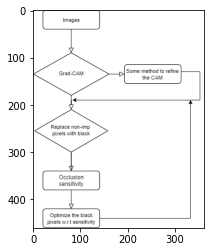

In [9]:
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['New_model.png']))
plt.imshow(im)
plt.show()

## My approach:
* The above image can also be viewed [here](https://drive.google.com/file/d/151pmfk-ZCefakzILy3NVOZJEgRpeZcDh/view?usp=sharing)
* It is a fusion of the Grad CAM and occlusion sensitivity methods
* Take an image and initially apply Grad CAM on it and with some means try to refine the mask overlap with face of the dog(only in this case)
* After that replace the non-activated pixels with black pixels
* Now, calculate the occlusion sensitivity and the probabilities will reflect the correctness of the CAMs
* Maybe this can also be optimized, with the aim of increasing the class probability